# **ETHVision: ARIMA-Driven Ethereum Price Forecasting**

**Objective:**

- Evaluate multiple ARIMA, SARIMA, and SARIMAX model variants to forecast ETH/USD prices, selecting the best model based on RMSE, MAPE, and AIC.

## **1.0 Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import itertools
import warnings
warnings.filterwarnings('ignore')
import joblib
import datetime
import json
import os
from sklearn.model_selection import TimeSeriesSplit

## **2.0 Set plot style for professional visuals**

In [2]:
sns.set_palette('viridis')

## **3.0 Load preprocessed ETH/USD data**

In [3]:
df = pd.read_csv('../Data/eth_usdt_data.csv', parse_dates=['Date'], index_col='Date')
series = df['Close']
print('Data Loaded Successfully')
print(series.head())

Data Loaded Successfully
Date
2017-11-09    320.884003
2017-11-10    299.252991
2017-11-11    314.681000
2017-11-12    307.907990
2017-11-13    316.716003
Name: Close, dtype: float64


In [4]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,1041889984


## **4.0 Stationarity Testing**

In [5]:
def adf_test(series, title=''):
    result = adfuller(series.dropna())
    print(f'\nADF Test for {title}:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Stationary' if result[1] < 0.05 else 'Non-Stationary')
    return result[1]

### **4.1 Test raw and differenced series**

In [6]:
adf_test(series, 'Raw Closing Price')
series_diff = series.diff().dropna()
adf_pvalue = adf_test(series_diff, 'Differenced Closing Price')


ADF Test for Raw Closing Price:
ADF Statistic: -1.7330
p-value: 0.4142
Non-Stationary

ADF Test for Differenced Closing Price:
ADF Statistic: -13.0329
p-value: 0.0000
Stationary


### **4.2 Plot differenced series**

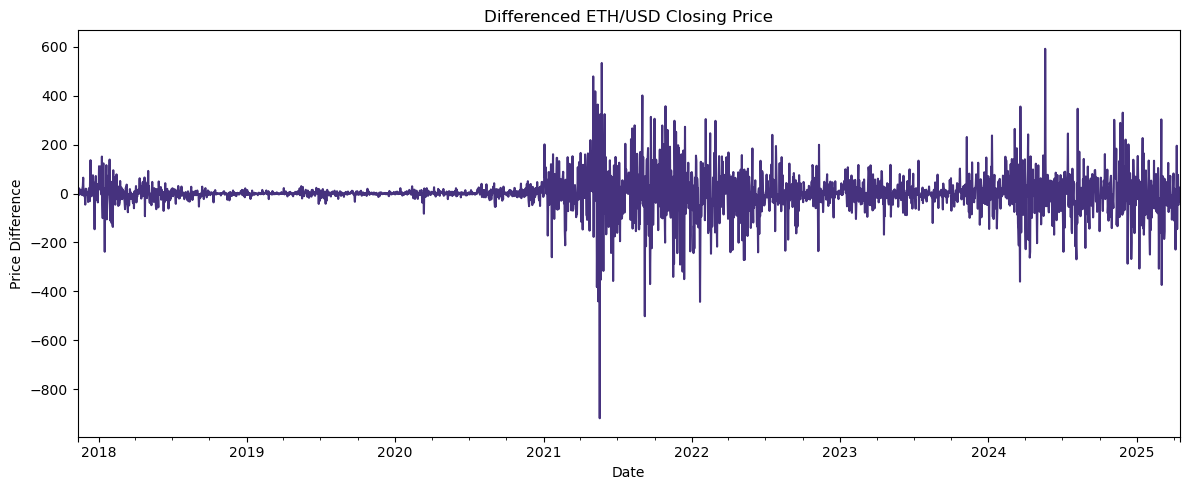

In [7]:
plt.figure(figsize=(12,5))
series_diff.plot(title='Differenced ETH/USD Closing Price')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.tight_layout()
plt.show()

### **4.3 Confirm differencing requirement**

In [8]:
d = 0
series_temp = series.copy()
while adf_test(series_temp, f"Series with d={d}") > 0.05 and d < 2:
    d += 1
    series_temp = series_temp.diff().dropna()
print(f"Selected differencing order: d={d}")


ADF Test for Series with d=0:
ADF Statistic: -1.7330
p-value: 0.4142
Non-Stationary

ADF Test for Series with d=1:
ADF Statistic: -13.0329
p-value: 0.0000
Stationary
Selected differencing order: d=1


## **5.0 ARIMA, SARIMA, SARIMAX Parameter Selection**

### **5.1 ACF and PACF plots for manual inspection**

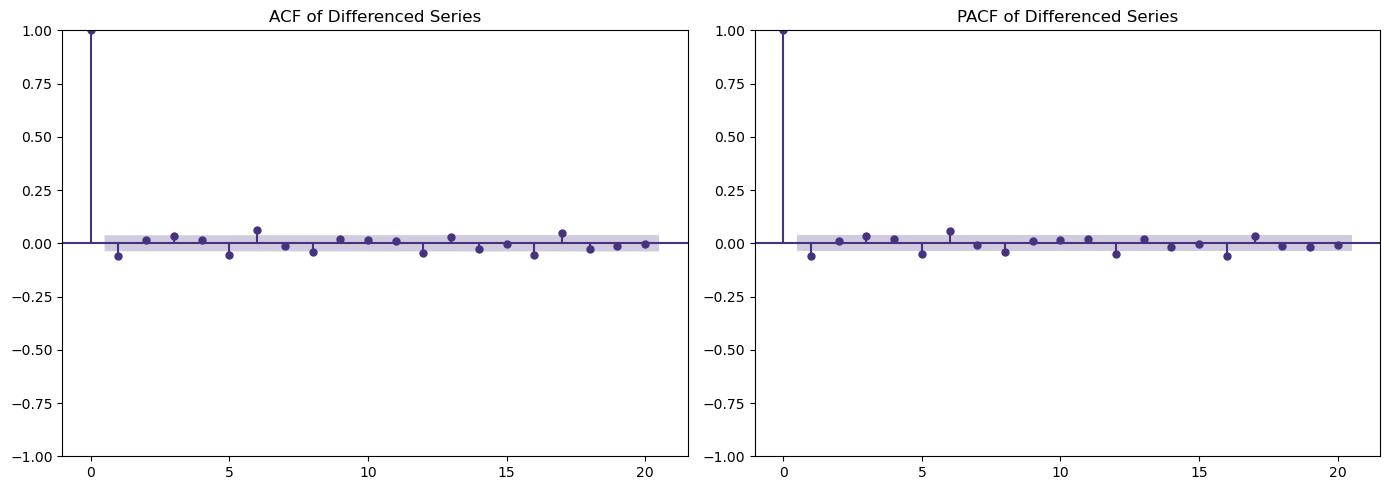

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(series_diff, lags=20, ax=ax1)
plot_pacf(series_diff, lags=20, ax=ax2)
ax1.set_title('ACF of Differenced Series')
ax2.set_title('PACF of Differenced Series')
plt.tight_layout()
plt.show()

### **5.2 Auto-ARIMA for baseline parameters**

In [10]:
print('\nRunning auto_arima...')
auto_model = auto_arima(series, start_p=0, start_q=0, max_p=5, max_q=5, d=d, seasonal=False)
print(auto_model.summary())
auto_order = auto_model.order
print(f'Auto-ARIMA Selected Order: {auto_order}')


Running auto_arima...
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2717
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -15767.073
Date:                Mon, 21 Apr 2025   AIC                          31538.146
Time:                        10:56:40   BIC                          31549.960
Sample:                    11-09-2017   HQIC                         31542.417
                         - 04-17-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0598      0.011     -5.462      0.000      -0.081      -0.038
sigma2      6457.3458     64.803     99.646      0.000    6330.334    6584.357
Ljung-Box (L1) (Q):          

## **6.0 Train and Test Split**

In [11]:
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]
print(f'\nTraining Set Size: {len(train)} days')
print(f'Test Set Size: {len(test)} days')


Training Set Size: 2173 days
Test Set Size: 544 days


- **6.1 Define and Train Models**

In [12]:
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]
print(f'\nTraining Set Size: {len(train)} days')
print(f'Test Set Size: {len(test)} days')


Training Set Size: 2173 days
Test Set Size: 544 days


In [13]:
# Define ARIMA orders
arima_orders = [(2,1,1), (0,1,0), (2,1,0), (1,1,2), (2,1,2), (0,1,2), (1,1,1), (0,1,1), (1,1,0)]

# Define SARIMA seasonal orders (weekly: 7 days, monthly: 30 days)
seasonal_orders = [
    (1,1,1,7),  # Weekly seasonality
    (1,1,1,30)  # Monthly seasonality
]


In [14]:
# Initialize results storage
results = []

# Train ARIMA models
for order in arima_orders:
    try:
        print(f'\nTraining ARIMA{order}...')
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        predictions = model_fit.forecast(steps=len(test))
        rmse = np.sqrt(mean_squared_error(test, predictions))
        mape = mean_absolute_percentage_error(test, predictions)
        results.append({
            'model_type': 'ARIMA',
            'order': order,
            'seasonal_order': None,
            'model_fit': model_fit,
            'predictions': predictions,
            'rmse': rmse,
            'mape': mape,
            'aic': model_fit.aic
        })
    except Exception as e:
        print(f'Failed to fit ARIMA{order}: {str(e)}')

# Train SARIMA models
for order in arima_orders:
    for s_order in seasonal_orders:
        try:
            print(f'\nTraining SARIMA{order}{s_order}...')
            model = SARIMAX(train, order=order, seasonal_order=s_order)
            model_fit = model.fit(disp=False)
            predictions = model_fit.forecast(steps=len(test))
            rmse = np.sqrt(mean_squared_error(test, predictions))
            mape = mean_absolute_percentage_error(test, predictions)
            results.append({
                'model_type': 'SARIMA',
                'order': order,
                'seasonal_order': s_order,
                'model_fit': model_fit,
                'predictions': predictions,
                'rmse': rmse,
                'mape': mape,
                'aic': model_fit.aic
            })
        except Exception as e:
            print(f'Failed to fit SARIMA{order}{s_order}: {str(e)}')

# Train SARIMAX with Volume as exogenous variable
exog_train = df['Volume'][:train_size]
exog_test = df['Volume'][train_size:]
for order in arima_orders:
    try:
        print(f'\nTraining SARIMAX{order} with Volume...')
        model = SARIMAX(train, exog=exog_train, order=order, seasonal_order=(0,0,0,0))
        model_fit = model.fit(disp=False)
        predictions = model_fit.forecast(steps=len(test), exog=exog_test)
        rmse = np.sqrt(mean_squared_error(test, predictions))
        mape = mean_absolute_percentage_error(test, predictions)
        results.append({
            'model_type': 'SARIMAX',
            'order': order,
            'seasonal_order': None,
            'model_fit': model_fit,
            'predictions': predictions,
            'rmse': rmse,
            'mape': mape,
            'aic': model_fit.aic
        })
    except Exception as e:
        print(f'Failed to fit SARIMAX{order}: {str(e)}')


Training ARIMA(2, 1, 1)...

Training ARIMA(0, 1, 0)...

Training ARIMA(2, 1, 0)...

Training ARIMA(1, 1, 2)...

Training ARIMA(2, 1, 2)...

Training ARIMA(0, 1, 2)...

Training ARIMA(1, 1, 1)...

Training ARIMA(0, 1, 1)...

Training ARIMA(1, 1, 0)...

Training SARIMA(2, 1, 1)(1, 1, 1, 7)...

Training SARIMA(2, 1, 1)(1, 1, 1, 30)...

Training SARIMA(0, 1, 0)(1, 1, 1, 7)...

Training SARIMA(0, 1, 0)(1, 1, 1, 30)...

Training SARIMA(2, 1, 0)(1, 1, 1, 7)...

Training SARIMA(2, 1, 0)(1, 1, 1, 30)...

Training SARIMA(1, 1, 2)(1, 1, 1, 7)...

Training SARIMA(1, 1, 2)(1, 1, 1, 30)...

Training SARIMA(2, 1, 2)(1, 1, 1, 7)...

Training SARIMA(2, 1, 2)(1, 1, 1, 30)...

Training SARIMA(0, 1, 2)(1, 1, 1, 7)...

Training SARIMA(0, 1, 2)(1, 1, 1, 30)...

Training SARIMA(1, 1, 1)(1, 1, 1, 7)...

Training SARIMA(1, 1, 1)(1, 1, 1, 30)...

Training SARIMA(0, 1, 1)(1, 1, 1, 7)...

Training SARIMA(0, 1, 1)(1, 1, 1, 30)...

Training SARIMA(1, 1, 0)(1, 1, 1, 7)...

Training SARIMA(1, 1, 0)(1, 1, 1, 30)...



- **6.2 Select Best Model**

In [15]:
if results:
    best_idx = np.argmin([r['rmse'] for r in results])
    best_model = results[best_idx]
    best_order = best_model['order']
    best_model_fit = best_model['model_fit']
    best_predictions = best_model['predictions']
    best_model_type = best_model['model_type']
    best_seasonal_order = best_model['seasonal_order']

    print(f'\nBest Model: {best_model_type}{best_order}' + (f'{best_seasonal_order}' if best_seasonal_order else ''))
    print(f'RMSE: {best_model["rmse"]:.2f}')
    print(f'MAPE: {best_model["mape"]:.4f}')
    print(f'AIC: {best_model["aic"]:.2f}')

    # Create results DataFrame
    results_df = pd.DataFrame([
        {
            'model_type': r['model_type'],
            'order': r['order'],
            'seasonal_order': r['seasonal_order'],
            'rmse': r['rmse'],
            'mape': r['mape'],
            'aic': r['aic']
        } for r in results
    ])
    results_df = results_df.sort_values('rmse')
    print('\nModel Comparison:')
    print(results_df[['model_type', 'order', 'seasonal_order', 'rmse', 'mape', 'aic']])
else:
    print('No models were successfully trained.')


Best Model: SARIMA(2, 1, 1)(1, 1, 1, 7)
RMSE: 1191.46
MAPE: 0.3405
AIC: 24880.74

Model Comparison:
   model_type      order seasonal_order         rmse      mape           aic
9      SARIMA  (2, 1, 1)   (1, 1, 1, 7)  1191.458690  0.340471  24880.744821
15     SARIMA  (1, 1, 2)   (1, 1, 1, 7)  1194.328942  0.341490  24880.464782
19     SARIMA  (0, 1, 2)   (1, 1, 1, 7)  1194.534076  0.341562  24880.344430
13     SARIMA  (2, 1, 0)   (1, 1, 1, 7)  1194.814011  0.341664  24880.608293
17     SARIMA  (2, 1, 2)   (1, 1, 1, 7)  1195.129182  0.341746  24893.522893
21     SARIMA  (1, 1, 1)   (1, 1, 1, 7)  1195.162363  0.341789  24880.757443
25     SARIMA  (1, 1, 0)   (1, 1, 1, 7)  1195.520058  0.341918  24878.936814
23     SARIMA  (0, 1, 1)   (1, 1, 1, 7)  1195.711224  0.341987  24879.219684
11     SARIMA  (0, 1, 0)   (1, 1, 1, 7)  1196.413495  0.342136  24885.918857
22     SARIMA  (1, 1, 1)  (1, 1, 1, 30)  1218.247030  0.349770  24696.686336
10     SARIMA  (2, 1, 1)  (1, 1, 1, 30)  1218.806590

## **7. Model Diagnostics**

### **7.1 Plot actual vs predicted for best model**

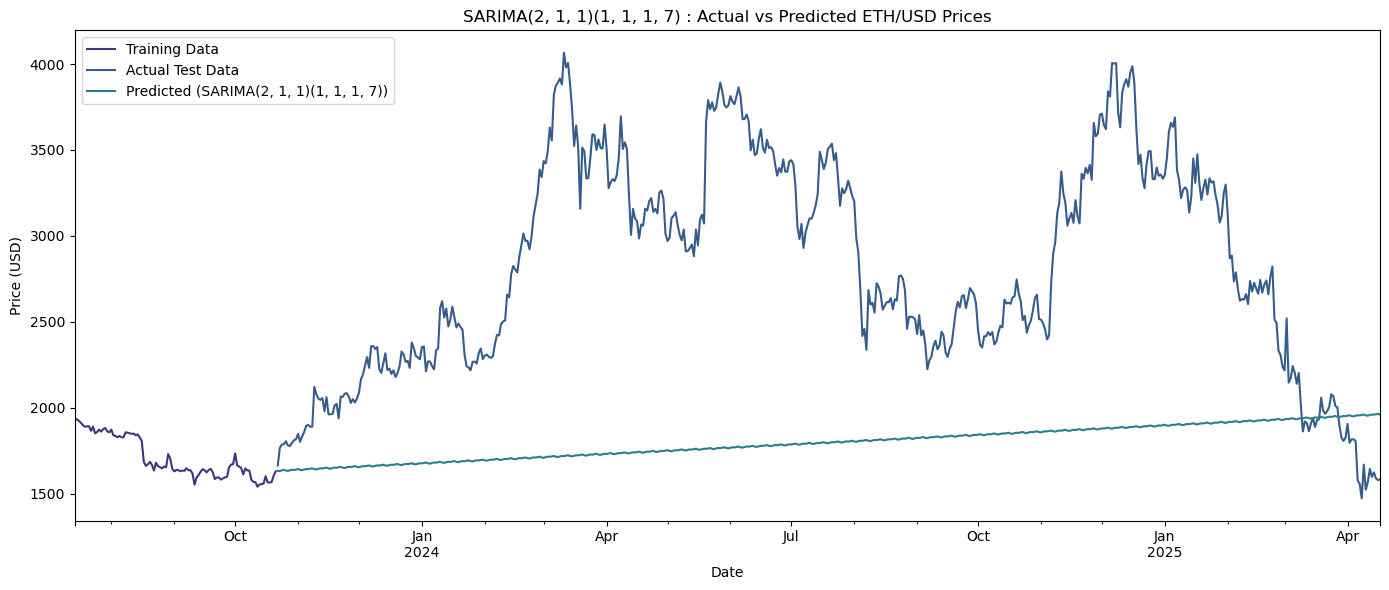

In [16]:
if 'best_model' in locals() and 'predictions' in best_model:
    plt.figure(figsize=(14,6))
    train[-100:].plot(label='Training Data')
    test.plot(label='Actual Test Data')
    best_predictions.plot(label=f'Predicted ({best_model_type}{best_order}{best_seasonal_order if best_seasonal_order else ""})')
    plt.title(f'{best_model_type}{best_order}{best_seasonal_order if best_seasonal_order else ""} : Actual vs Predicted ETH/USD Prices')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('Cannot plot predictions - no best model selected')

### **7.2 Residual analysis**

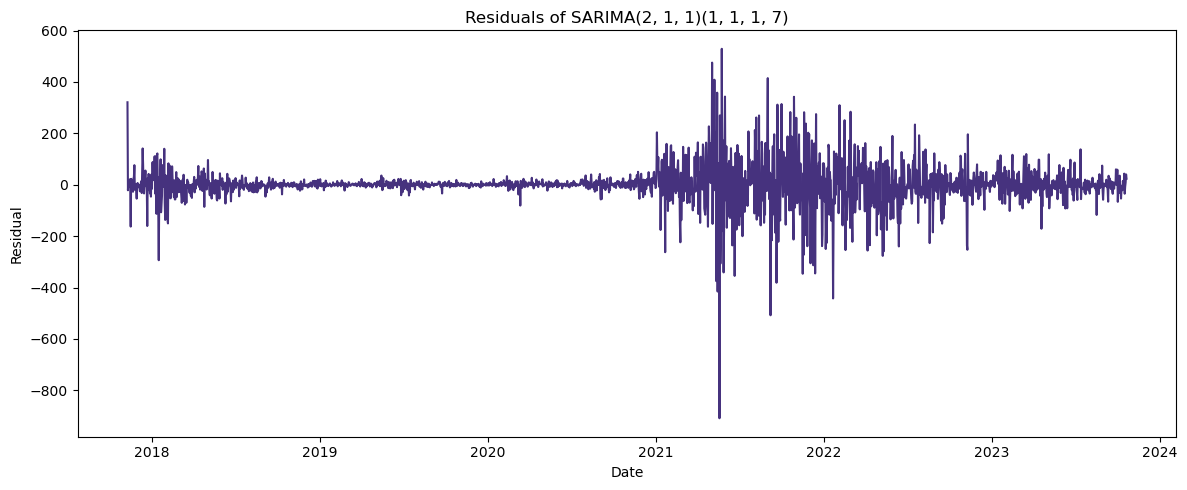

In [17]:
residuals = best_model_fit.resid
plt.figure(figsize=(12,5))
plt.plot(residuals)
plt.title(f'Residuals of {best_model_type}{best_order}{best_seasonal_order if best_seasonal_order else ""}')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.tight_layout()
plt.show()

### **7.3 ACF of residuals**

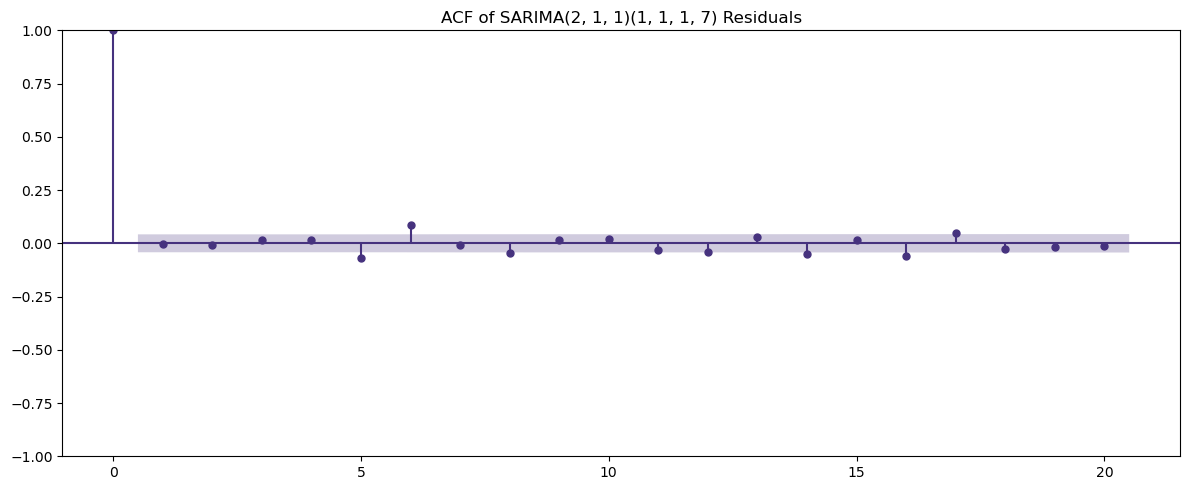

In [18]:
if 'best_model_fit' in locals():
    fig, ax = plt.subplots(figsize=(12,5))
    plot_acf(residuals, lags=20, ax=ax)
    ax.set_title(f'ACF of {best_model_type}{best_order}{best_seasonal_order if best_seasonal_order else ""} Residuals')
    plt.tight_layout()
    plt.show()
else:
    print('No residuals available for plotting')


### **7.4 Residual distribution**

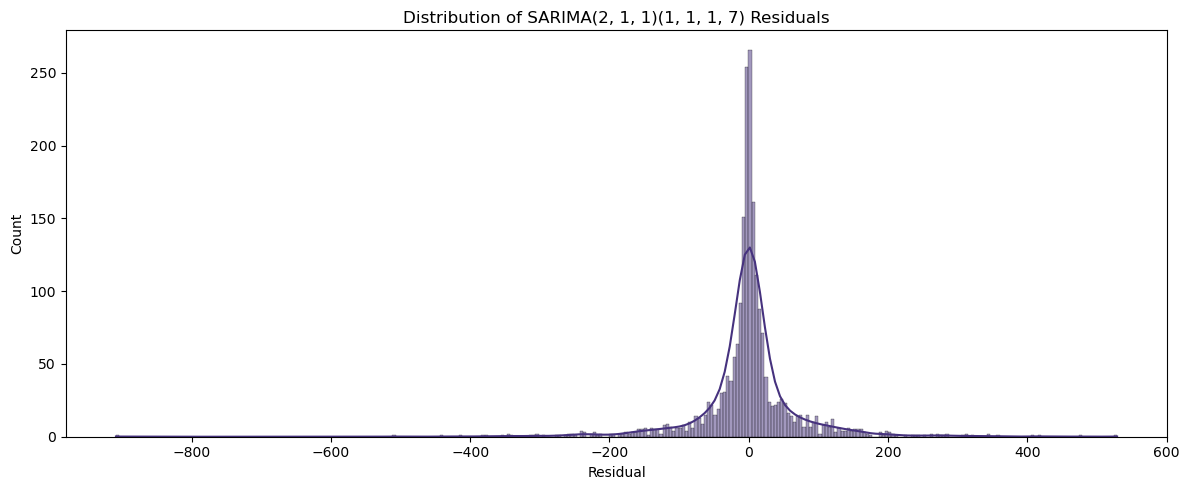

In [19]:
plt.figure(figsize=(12,5))
sns.histplot(residuals, kde=True)
plt.title(f'Distribution of {best_model_type}{best_order}{best_seasonal_order if best_seasonal_order else ""} Residuals')
plt.xlabel('Residual')
plt.tight_layout()
plt.show()

## **8.0 Forecasting with Best Model**

### **8.1 Forecast 30 days into the future**

In [20]:
if best_model_type == 'SARIMAX':
    forecast_obj = best_model_fit.get_forecast(steps=30, exog=exog_test[-30:])
else:
    forecast_obj = best_model_fit.get_forecast(steps=30)
forecast = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()

### **8.2 Create forecast index**

In [21]:
last_date = series.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')
forecast_series = pd.Series(forecast, index=forecast_index)
conf_int.index = forecast_index

### **8.3 Plot forecast**

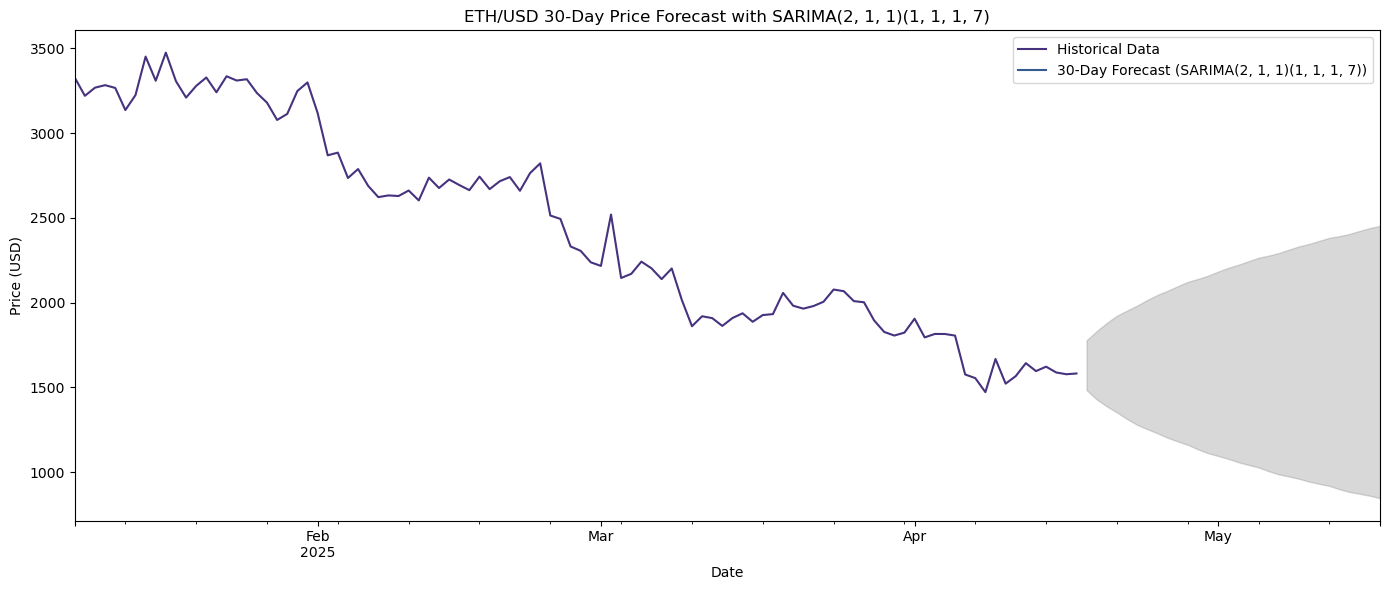

In [22]:
plt.figure(figsize=(14,6))
series[-100:].plot(label='Historical Data')
forecast_series.plot(label=f'30-Day Forecast ({best_model_type}{best_order}{best_seasonal_order if best_seasonal_order else ""})')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3)
plt.title(f'ETH/USD 30-Day Price Forecast with {best_model_type}{best_order}{best_seasonal_order if best_seasonal_order else ""}')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

### **8.4 Forecast summary**

In [23]:
if 'forecast_obj' in locals():
    print('\nDebug: Forecast Values')
    print(forecast.head())
    print('\n30-Day Forecast Summary:')
    print(forecast_series.describe())
else:
    print('No forecast object available')


Debug: Forecast Values
2023-10-22    1631.531311
2023-10-23    1631.031269
2023-10-24    1634.774449
2023-10-25    1638.150769
2023-10-26    1633.604404
Freq: D, Name: predicted_mean, dtype: float64

30-Day Forecast Summary:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: predicted_mean, dtype: float64


## **9.0 Save Results for Portfolio**

### **9.1 Save model comparison table**

In [24]:
results_df.to_csv('../Artifacts/arima_model_comparison.csv', index=False)
print('\nModel comparison saved to arima_model_comparison.csv')


Model comparison saved to arima_model_comparison.csv


### **9.2 Plot forecast**

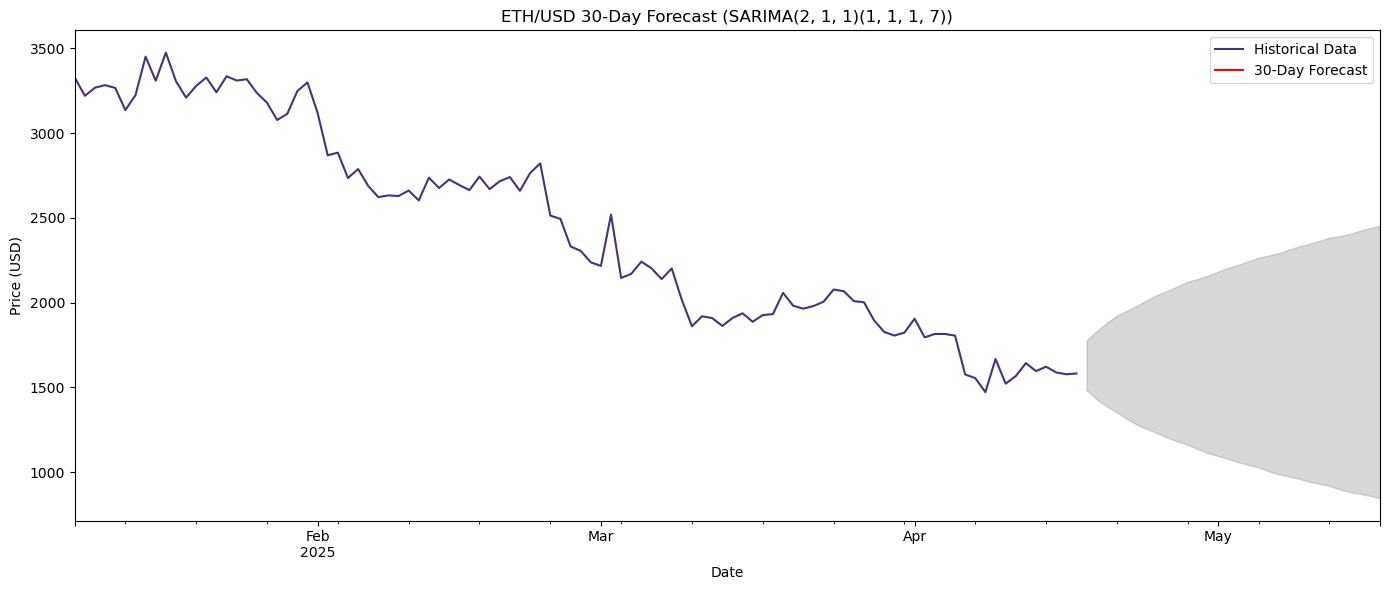

In [25]:
plt.figure(figsize=(14,6))
series[-100:].plot(label='Historical Data')
forecast_series.plot(label='30-Day Forecast', color='red')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3)
plt.title(f'ETH/USD 30-Day Forecast ({best_model_type}{best_order}{best_seasonal_order if best_seasonal_order else ""})')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

### **9.3 Save best model**

In [26]:
if 'best_model_fit' in locals():
    try:
        artifacts_dir = '../Artifacts'
        os.makedirs(artifacts_dir, exist_ok=True)
        date_str = datetime.date.today().strftime('%Y%m%d')
        model_filename = f'{artifacts_dir}/model_eth.pkl'
        metadata_filename = f'{artifacts_dir}/model_metadata.json'
        joblib.dump(best_model_fit, model_filename)
        model_meta = {
            'model_type': best_model_type,
            'order': tuple(best_order),
            'seasonal_order': tuple(best_seasonal_order) if best_seasonal_order else None,
            'rmse': float(best_model['rmse']),
            'mape': float(best_model['mape']),
            'aic': float(best_model['aic']),
            'last_training_date': series.index[-1].strftime('%Y-%m-%d'),
            'model_file': model_filename
        }
        with open(metadata_filename, 'w') as f:
            json.dump(model_meta, f, indent=4)
        print(f'\nModel saved to {model_filename}')
        print(f'Metadata saved to {metadata_filename}')
    except Exception as e:
        print(f'Error saving model or metadata: {str(e)}')
else:
    print('No model to save')


Model saved to ../Artifacts/model_eth.pkl
Metadata saved to ../Artifacts/model_metadata.json


## **10.0 Cross-Validation**

In [27]:
if 'best_order' in locals():
    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []
    print(f'\nCross-Validating {best_model_type}{best_order}{best_seasonal_order if best_seasonal_order else ""}...')
    for train_idx, test_idx in tscv.split(series):
        train_cv, test_cv = series.iloc[train_idx], series.iloc[test_idx]
        if best_model_type == 'SARIMAX':
            exog_cv_train = df['Volume'].iloc[train_idx]
            exog_cv_test = df['Volume'].iloc[test_idx]
            model = SARIMAX(train_cv, exog=exog_cv_train, order=best_order, seasonal_order=(0,0,0,0))
        elif best_model_type == 'SARIMA':
            model = SARIMAX(train_cv, order=best_order, seasonal_order=best_seasonal_order)
        else:
            model = ARIMA(train_cv, order=best_order)
        model_fit = model.fit(disp=False)
        if best_model_type == 'SARIMAX':
            predictions = model_fit.forecast(steps=len(test_cv), exog=exog_cv_test)
        else:
            predictions = model_fit.forecast(steps=len(test_cv))
        rmse = np.sqrt(mean_squared_error(test_cv, predictions))
        rmse_scores.append(rmse)
        print(f'Fold RMSE: {rmse:.2f}')
    print(f'Mean CV RMSE: {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}')
else:
    print('No best model available for cross-validation')


Cross-Validating SARIMA(2, 1, 1)(1, 1, 1, 7)...
Fold RMSE: 180.54
Fold RMSE: 1398.92
Fold RMSE: 1254.36
Fold RMSE: 248.80
Fold RMSE: 705.51
Mean CV RMSE: 757.62 ± 500.53


## **Summary for Documentation**

In [28]:
print('\nProject Summary:')
print(f'- Data: ETH/USD daily closing prices from 2017-11-09 to 2025-04-17')
print(f'- Stationarity: Achieved with d={d} differencing (ADF p-value: {adf_pvalue:.4f})')
print(f'- Models Tested: {len(results)} variants (ARIMA, SARIMA, SARIMAX)')
print(f'- Best Model: {best_model_type}{best_order}{best_seasonal_order if best_seasonal_order else ""} (RMSE: {best_model["rmse"]:.2f}, MAPE: {best_model["mape"]:.4f})')
print('- Forecast: 30-day projection with 95% confidence intervals')
print('- Insights: Model captures short-term trends; crypto volatility limits long-term accuracy')
print('Recommendation: Consider hybrid models (e.g., ARIMA-LSTM) or additional exogenous variables for enhanced volatility modeling')


Project Summary:
- Data: ETH/USD daily closing prices from 2017-11-09 to 2025-04-17
- Stationarity: Achieved with d=1 differencing (ADF p-value: 0.0000)
- Models Tested: 36 variants (ARIMA, SARIMA, SARIMAX)
- Best Model: SARIMA(2, 1, 1)(1, 1, 1, 7) (RMSE: 1191.46, MAPE: 0.3405)
- Forecast: 30-day projection with 95% confidence intervals
- Insights: Model captures short-term trends; crypto volatility limits long-term accuracy
Recommendation: Consider hybrid models (e.g., ARIMA-LSTM) or additional exogenous variables for enhanced volatility modeling
